In [19]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score,accuracy_score



In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

from tensorflow.keras.models import load_model

In [21]:
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, ResNet152,VGG19
from tensorflow.keras.optimizers import Adam

In [22]:
base_path = '/kaggle/input/food-101/food-101/food-101/'
meta_path = os.path.join(base_path, 'meta')
images_path = os.path.join(base_path, 'images')

In [23]:
image_dir = Path('/kaggle/input/food-101/food-101/food-101/')

In [24]:
image_dir = Path('/kaggle/input/food-101/food-101/food-101/')

In [25]:
filepaths = list(image_dir.glob(r'**/*.jpg'))

In [26]:
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

images = pd.concat([filepaths, labels], axis=1)

In [27]:
category_samples = []
for category in images['Label'].unique():
    category_slice = images.query("Label == @category")
    category_samples.append(category_slice)
image_df = pd.concat(category_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)

In [28]:
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

In [29]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
validation_split=0.2
)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [30]:
input_shape = (224,224)
batch_size = 256

In [31]:

train_images = train_generator.flow_from_dataframe(
dataframe=train_df,
x_col='Filepath',
y_col='Label',
target_size=input_shape,
color_mode='rgb',
class_mode='categorical',
batch_size=batch_size,
shuffle=True,
seed=42,
subset='training'
)
val_images = train_generator.flow_from_dataframe(
dataframe=train_df,
x_col='Filepath',
y_col='Label',
target_size=input_shape,
color_mode='rgb',
class_mode='categorical',
batch_size=batch_size,
shuffle=True,
seed=42,
subset='validation'
)
test_images = test_generator.flow_from_dataframe(
dataframe=test_df,
x_col='Filepath',
y_col='Label',
target_size=input_shape,
color_mode='rgb',
class_mode='categorical',
batch_size=batch_size,
shuffle=False
)

Found 56560 validated image filenames belonging to 101 classes.
Found 14140 validated image filenames belonging to 101 classes.
Found 30300 validated image filenames belonging to 101 classes.


In [32]:
def print_header(title):
    print("\n" + "="*50)
    print(f"{title.center(50)}")
    print("="*50 + "\n")

def plot_history(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss')
    plt.show()

def model_evaluation(model, test_images, ):
    # Print Header for Evaluation    
    print_header('MODEL EVALUATION')

    # Predict on Test Images
    test_preds = model.predict(test_images)
    test_labels = test_images.labels  

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(test_labels, test_preds.argmax(axis=1)))

    # Confusion Matrix
    print("\nConfusion Matrix:")
    cm = confusion_matrix(test_labels, test_preds.argmax(axis=1))
    plt.figure(figsize=(20, 20))
    sns.heatmap(
        cm,
        fmt='d',
        cmap='Blues',
        xticklabels=test_images.class_indices.keys(),
        yticklabels=test_images.class_indices.keys()
    )
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

    


In [33]:

# Custom Callback for Loss Improvement Logging
class LossImprovementCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch == 0:
            self.prev_loss = logs.get('val_loss')
        else:
            improvement = self.prev_loss - logs.get('val_loss')
            print(f"Epoch {epoch + 1}: Validation Loss Improvement: {improvement:.4f}")
            self.prev_loss = logs.get('val_loss')

def pretrained_model_fit(pretrained_model,model_name,train_images,val_images, test_images,epochs= 20,monitor = 'val_loss',monitor_mode = 'auto'):
    inputs = pretrained_model.input
    x = tf.keras.layers.Dense(1024, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dropout(0.25)(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    outputs = tf.keras.layers.Dense(101, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)

    print_header('SUMMARY OF THE MODEL')
    print(model.summary())
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy', 'AUC']
    )

    # Model Training
    print_header('MODEL TRAINING')
    checkpoint_filepath = f'best_{model_name}.keras'
    checkpoint = ModelCheckpoint(
        checkpoint_filepath,
        save_best_only=True,
        monitor=monitor,
        mode=monitor_mode,
        verbose=1
    )
    history = model.fit(
        train_images,
        validation_data=val_images,
        epochs=epochs,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor=monitor,
                patience=5,
                restore_best_weights=True
            ),
            checkpoint,
            LossImprovementCallback()
        ]
    )
    print_header('TRAINING HISTORY PLOTS')
    plot_history(history)    
    best_model = load_model(checkpoint_filepath)
    return best_model



In [34]:
vgg19_model = tf.keras.applications.VGG19(
input_shape=(224, 224, 3),
include_top=False,
weights='imagenet',
pooling='avg'
)
vgg19_model.trainable = False


               SUMMARY OF THE MODEL               



Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 21,702,821 (82.79 MB)

 Trainable params: 1,678,437 (6.40 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

None

                  MODEL TRAINING                  

Epoch 1/20


2024-12-10 21:28:09.745364: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng18{k2=2,k4=1,k5=0,k6=0,k7=0} for conv (f32[256,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[256,64,224,224]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-12-10 21:28:09.907673: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.162437228s
Trying algorithm eng18{k2=2,k4=1,k5=0,k6=0,k7=0} for conv (f32[256,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[256,64,224,224]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivatio

 42/221 ━━━━━━━━━━━━━━━━━━━━ 6:50 2s/step - AUC: 0.5565 - accuracy: 0.0250 - loss: 4.5965

2024-12-10 21:31:07.193115: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng18{k2=2,k4=1,k5=0,k6=0,k7=0} for conv (f32[240,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[240,64,224,224]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-12-10 21:31:07.204717: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.011710513s
Trying algorithm eng18{k2=2,k4=1,k5=0,k6=0,k7=0} for conv (f32[240,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[240,64,224,224]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivatio

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - AUC: 0.7280 - accuracy: 0.0928 - loss: 4.0766
Epoch 1: val_loss improved from inf to 2.97890, saving model to best_VGG19.keras
221/221 ━━━━━━━━━━━━━━━━━━━━ 862s 3s/step - AUC: 0.7284 - accuracy: 0.0931 - loss: 4.0746 - val_AUC: 0.9004 - val_accuracy: 0.2754 - val_loss: 2.9789
Epoch 2/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - AUC: 0.9003 - accuracy: 0.2751 - loss: 2.9470
Epoch 2: val_loss improved from 2.97890 to 2.67417, saving model to best_VGG19.keras
Epoch 2: Validation Loss Improvement: 0.3047
221/221 ━━━━━━━━━━━━━━━━━━━━ 411s 2s/step - AUC: 0.9003 - accuracy: 0.2751 - loss: 2.9467 - val_AUC: 0.9197 - val_accuracy: 0.3495 - val_loss: 2.6742
Epoch 3/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - AUC: 0.9166 - accuracy: 0.3302 - loss: 2.6886
Epoch 3: val_loss improved from 2.67417 to 2.56601, saving model to best_VGG19.keras
Epoch 3: Validation Loss Improvement: 0.1082
221/221 ━━━━━━━━━━━━━━━━━━━━ 411s 2s/step - AUC: 0.9166 - accuracy: 0.330

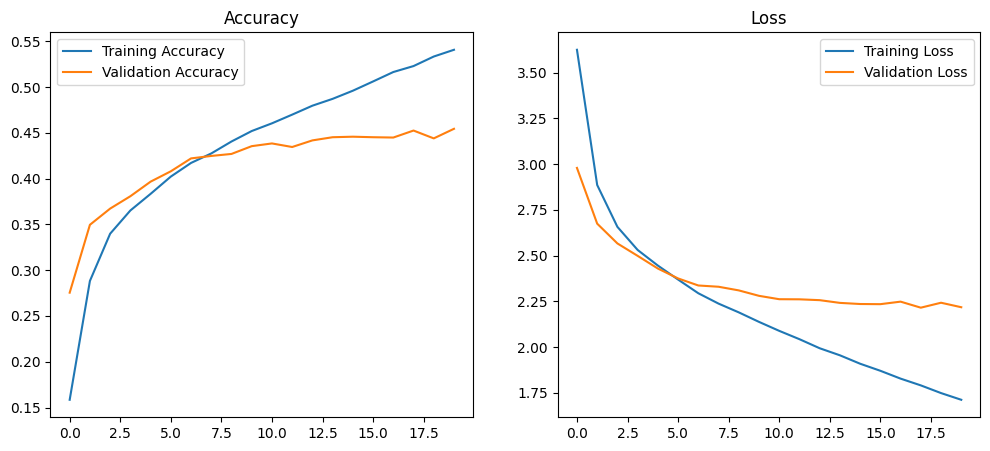

In [35]:
vgg19_model = pretrained_model_fit(vgg19_model,'VGG19',train_images,val_images,test_images)


                 MODEL EVALUATION                 

119/119 ━━━━━━━━━━━━━━━━━━━━ 360s 3s/step

Classification Report:
              precision    recall  f1-score   support

           0       0.26      0.11      0.15       297
           1       0.38      0.48      0.43       285
           2       0.46      0.42      0.44       293
           3       0.38      0.43      0.41       273
           4       0.27      0.26      0.26       293
           5       0.33      0.36      0.34       291
           6       0.47      0.70      0.57       281
           7       0.55      0.67      0.60       303
           8       0.24      0.21      0.23       307
           9       0.38      0.19      0.25       323
          10       0.26      0.20      0.22       268
          11       0.43      0.60      0.50       303
          12       0.44      0.60      0.51       324
          13       0.39      0.35      0.37       298
          14       0.55      0.23      0.33       319
          15    

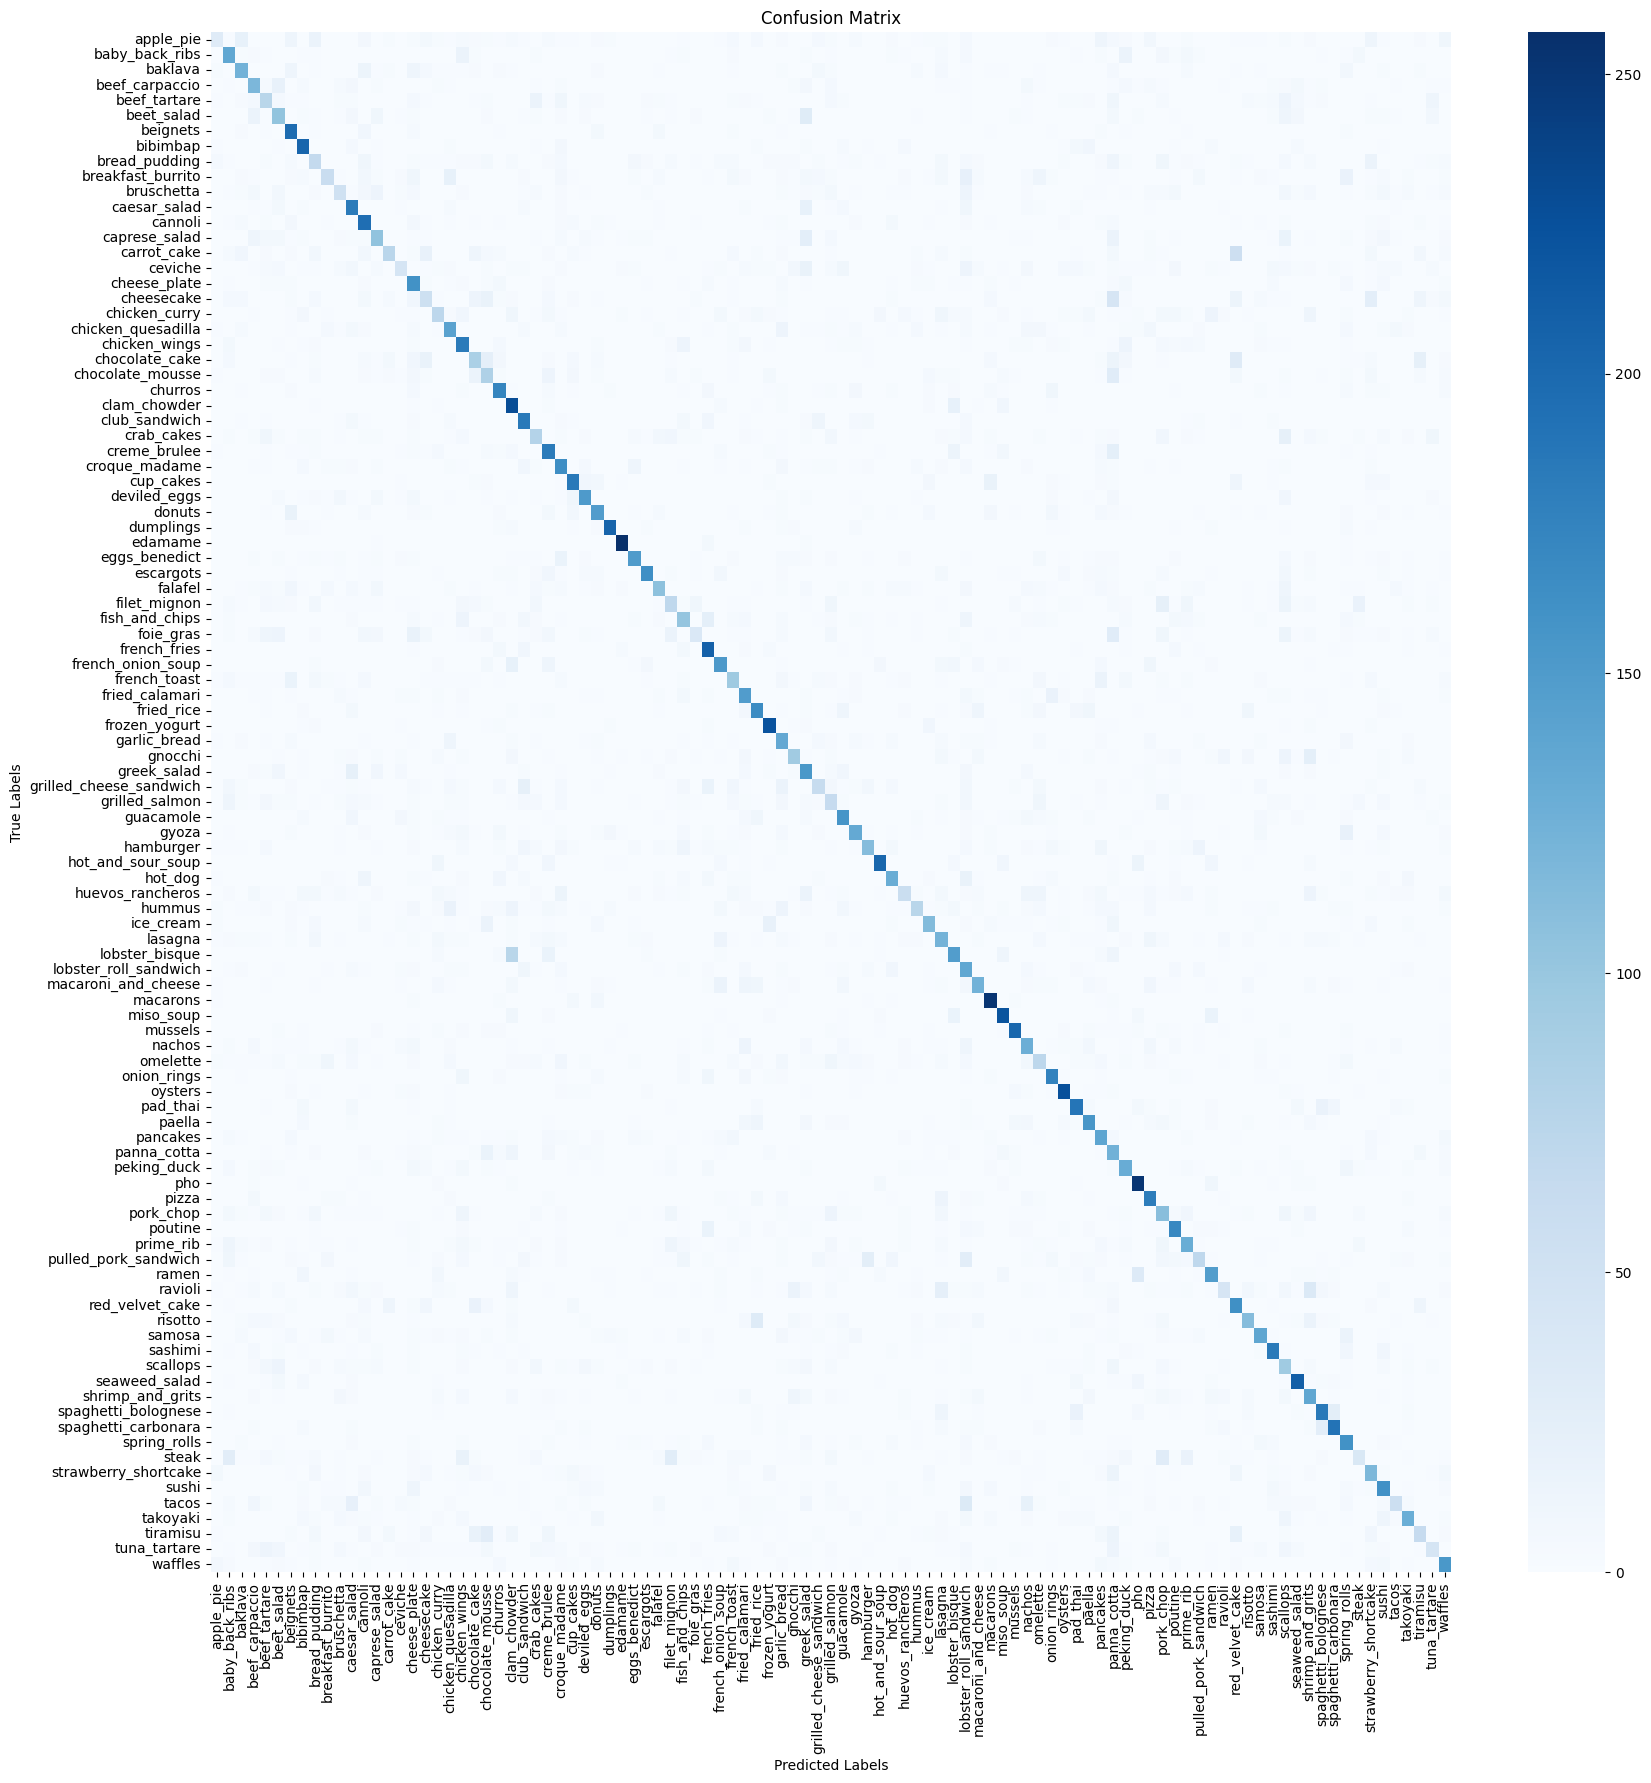

In [36]:
model_evaluation(vgg19_model,test_images)